#HW2

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.datasets
import scipy
import scipy.stats
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix
import sklearn.tree

## Loading the dataset

In [23]:
!rm *.csv

from google.colab import files
print("Please load the raw csv data")
uploadedData = files.upload()
filename = list(uploadedData)[0]

Please load the raw csv data


Saving test_data.csv to test_data.csv
Saving training_data.csv to training_data.csv


In [24]:
dataset = pd.read_csv(filename)

In [25]:
dataset.shape

(600, 20)

In [26]:
# from google.colab import files
# outputPath = "saved_file.csv"
# dataset.to_csv(outputPath)
# files.download(outputPath) 

**Knn class**

Init: initialize the model

Fit: memorize the trained data.

predict: find most freaquent label from the k nearest neighboors for
 each of the X samples.

In [27]:
from sklearn.base import BaseEstimator,ClassifierMixin
class kNN(BaseEstimator, ClassifierMixin):
  def __init__(self, n_neighbors:int = 5 ):
    self.n_neighbors = n_neighbors
    self.x_train = None
    self.y_train = None

  def fit(self, X, y):
    self.x_train = np.copy(X)  
    self.y_train = np.copy(y)
    return self
  def predict(self, X):
    predictions = []
    distX =scipy.spatial.distance.cdist(X,self.x_train,'euclidean')
    distSelection = np.argpartition(a= distX,axis=-1,kth = self.n_neighbors)
    firstKidx = distSelection[:,:self.n_neighbors]
    firstKlabels = np.apply_along_axis(func1d = (lambda idx: scipy.stats.mode((self.y_train[idx]))[0][0]), axis=-1, arr = firstKidx)
    predictions = firstKlabels
    return predictions 

visualize the decision boundries for the kNN

In [28]:
def visualize_clf(clf, X, Y, title, marker_size=250):
    import matplotlib.pyplot as plt
    from matplotlib.colors import ListedColormap

    plt.figure(figsize=(8, 8))

    # Parameters
    n_classes = 2
    markers = ["P", "v"]
    palette = sns.color_palette("hls", 2)
    custom_cmap = ListedColormap(palette.as_hex())
    plot_step = 0.02
    x_delta = np.abs(X[:, 0].max() - X[:, 0].min()) * 0.1
    y_delta = np.abs(X[:, 1].max() - X[:, 1].min()) * 0.1
    x_min, x_max = X[:, 0].min() - x_delta, X[:, 0].max() + x_delta
    y_min, y_max = X[:, 1].min() - y_delta, X[:, 1].max() + y_delta
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    cs = plt.contourf(xx, yy, Z, cmap=custom_cmap, alpha=0.35)

    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.grid(alpha=0.75)

    # Plot the training points
    for i, color, marker in zip(range(n_classes), palette, markers):
        idx = np.where(Y == i)
        plt.scatter(X[idx, 0], X[idx, 1], color=color,
                    marker=marker,
                    edgecolor='white', s=marker_size)

    plt.title(title, fontsize=20)
    plt.axis("tight")
    plt.show()

Check the kNN model with some toy data, and visualize the decisions



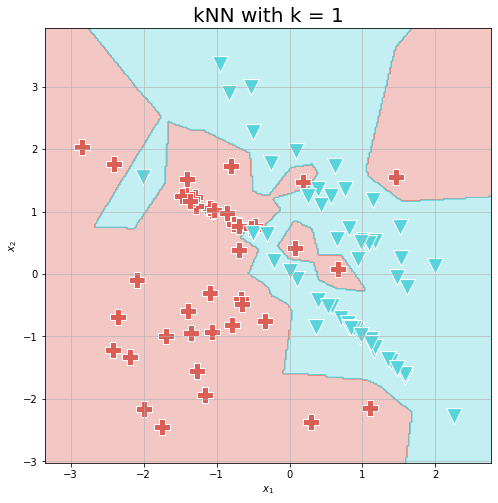

In [29]:
model = kNN()
X_toy, y_toy = sklearn.datasets.make_classification(n_samples=100, n_features=2,
 random_state=12, flip_y = 0.1,
 n_informative=2, n_redundant=0)
model = kNN(1)
model.fit(X_toy,y_toy)
visualize_clf(clf = model ,X = X_toy, Y = y_toy , title ="kNN with k = 1")

In [30]:
train_data =pd.read_csv('training_data.csv')
test_data =pd.read_csv('test_data.csv')
train_data = train_data.drop(['Unnamed: 0'],axis=1)
test_data = test_data.drop(['Unnamed: 0'],axis=1)
y = train_data[['covid','risk','spread']]
X = train_data.drop(['covid','risk','spread'],axis=1)  

Correlation between spread and other features

In [31]:
s = train_data.corr().spread.abs()
spread_corr = s.sort_values(kind="quicksort", ascending=False)
spread_corr[1:11]

PCR_10                          0.151594
blood_type_A+                   0.059768
PCR_07                          0.046893
household_income                0.034036
sex                             0.028666
symptoms_shortness_of_breath    0.023319
sugar_levels                    0.022069
symptoms_cough                  0.018483
PCR_01                          0.016312
PCR_06                          0.013586
Name: spread, dtype: float64

Scatter plot for PCR_03, PCR_07, and PCR_10

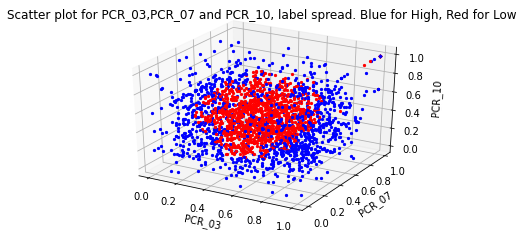

In [56]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for i in range(train_data.shape[0]):
    xs = train_data['PCR_03'][i]
    ys =  train_data['PCR_07'][i]
    zs = train_data['PCR_10'][i]
    if train_data['spread'][i] > 0:
      ax.scatter3D(xs,ys,zs,color="blue",label = 'High spread',s=5)
    else:
      ax.scatter3D(xs,ys,zs,color="red",label = 'Low spread',s=5)

ax.set_xlabel('PCR_03')
ax.set_ylabel('PCR_07')
ax.set_zlabel('PCR_10')
plt.title("Scatter plot for PCR_03,PCR_07 and PCR_10, label spread. Blue for High, Red for Low")
plt.grid()
plt.savefig("3dScattern.png",dpi = 400)
plt.show()

PCR analysis

In [66]:
PCR_data = train_data[['PCR_03','PCR_07','PCR_10']].copy()
PCR_test = test_data[['PCR_03','PCR_07','PCR_10']].copy()
spreads = train_data['spread']
test_spreads = test_data['spread']
model = kNN(11)
model.fit(PCR_data,spreads)
model.score(PCR_data,spreads)

0.9225

In [58]:
#PCR_data=(PCR_data-PCR_data.mean())/PCR_data.std()
PCR_data=(PCR_data-PCR_data.min())/(PCR_data.max()-PCR_data.min())
model = kNN(11)
model.fit(PCR_data,spreads)
model.score(PCR_data,spreads)

0.9225

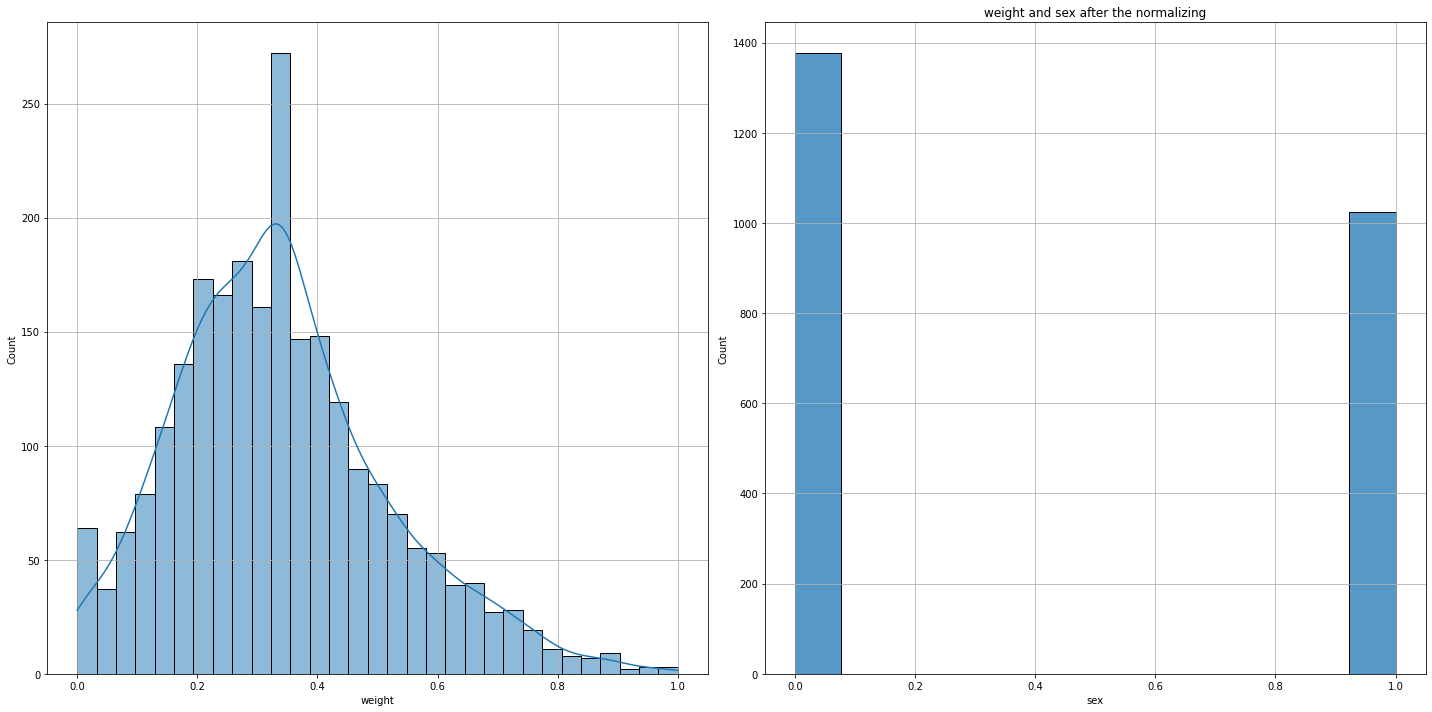

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
sns.histplot(ax=axes[0], data=train_data, x='weight', kde=True)
sns.histplot(ax=axes[1], data=train_data, x='sex')
axes[0].grid()
axes[1].grid()
plt.title("weight and sex after the normalizing")
plt.tight_layout()
plt.show()

Cross validation

7 0.9095833333333333


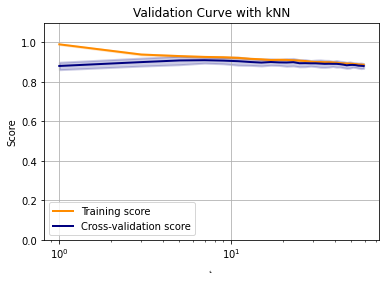

In [36]:
k_range = np.array((range (1,61,2)))
train_scores, test_scores  = sklearn.model_selection.validation_curve(kNN(1),PCR_data,spreads,param_name='n_neighbors',param_range=k_range,cv = 8)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with kNN")
plt.xlabel(r"$\k$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(
    k_range, train_scores_mean, label="Training score", color="darkorange", lw=lw
)
plt.fill_between(
    k_range,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
    color="darkorange",
    lw=lw,
)
plt.semilogx(
    k_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw
)
plt.fill_between(
    k_range,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.2,
    color="navy",
    lw=lw,
)
ymax = max(test_scores_mean)
index = np.argmax(test_scores_mean)
print(k_range[index],ymax)
plt.grid()
plt.legend(loc="best")
plt.show()

Error anaylsis

In [37]:

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
y_pred = cross_val_predict(kNN(1), PCR_data, spreads, cv=8)
conf_mat = confusion_matrix(spreads, y_pred)
print(conf_mat)

[[1051  142]
 [ 145 1062]]


Decision Trees

In [38]:
s = train_data.corr().risk.abs()
risk_corr = s.sort_values(kind="quicksort", ascending=False)
risk_corr[1:11]

sugar_levels       0.262572
PCR_06             0.194540
weight             0.158122
PCR_03             0.037509
blood_type_A+      0.032901
symptoms_fever     0.027266
PCR_02             0.026809
num_of_siblings    0.022001
sex                0.019875
PCR_01             0.019871
Name: risk, dtype: float64

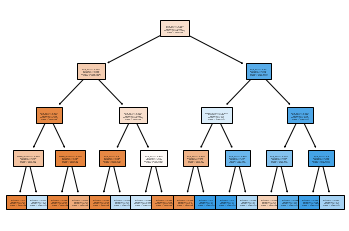

In [39]:
# Create Decision Tree classifer object
y = train_data[['covid','risk','spread']]
X = train_data.drop(['covid','risk','spread'],axis=1)  
clf = sklearn.tree.DecisionTreeClassifier(criterion="entropy", splitter='best', max_depth=4)

# Train Decision Tree Classifer
risks = train_data['risk']
clf = clf.fit(X,risks)
# Draw the tree
sklearn.tree.plot_tree(clf, feature_names=X.columns,filled=True
                       ,class_names = ['Low risk','High risk'],fontsize = 2)
plt.savefig("tree.png",dpi = 500)
plt.show()

In [40]:
from sklearn.metrics import accuracy_score
y_hat = clf.predict(X)
print('Model accuracy score with criterion entropy: {0:0.4f}'
. format(accuracy_score(train_data['risk'], y_hat)))

Model accuracy score with criterion entropy: 0.7392


In [41]:
from sklearn.model_selection import GridSearchCV
y = train_data[['covid','risk','spread']]
X = train_data.drop(['covid','risk','spread'],axis=1)  
parameters = {'max_depth':range(1,15,1),'min_samples_leaf':range(1,15,1)}
treeCV = GridSearchCV(clf, parameters,cv = 8,return_train_score=True)
treeCV.fit(X, risks)

y_hat = treeCV.predict(X)
print(treeCV.best_estimator_)
print('Model accuracy score with criterion entropy: {0:0.4f}'
. format(accuracy_score(train_data['risk'], y_hat)))
treeCV.score(X, risks)

DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=10)
Model accuracy score with criterion entropy: 0.9242


0.9241666666666667

DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=10) 0.8941666666666667


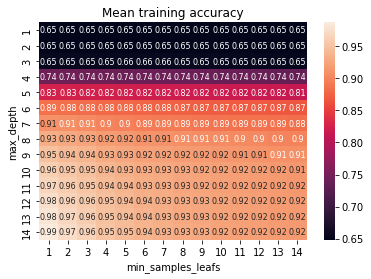

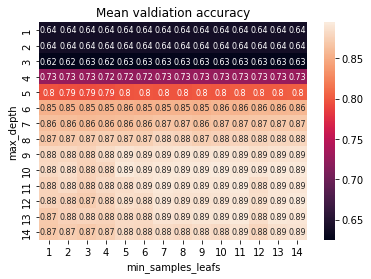

In [42]:
results = treeCV.cv_results_
mean_train = results['mean_train_score']
mean_test = results['mean_test_score']
print(treeCV.best_estimator_,treeCV.best_score_)
max_depth_list = list(range(1,15,1))
min_leafs_list = list(range(1,15,1))
mean_test = mean_test.reshape((14,14))
mean_train = mean_train.reshape((14,14))
sns.heatmap(annot_kws={'size': 8},xticklabels = min_leafs_list,yticklabels = max_depth_list, annot =True ,data = mean_train)
plt.title("Mean training accuracy")
plt.xlabel('min_samples_leafs', fontsize = 10) # x-axis label with fontsize 15
plt.ylabel('max_depth', fontsize = 10) # y-axis label with fontsize 15
plt.show()

sns.heatmap(annot_kws={'size': 8},xticklabels = min_leafs_list,yticklabels = max_depth_list, annot =True ,data = mean_test)
plt.title("Mean valdiation accuracy")
plt.xlabel('min_samples_leafs', fontsize = 10) # x-axis label with fontsize 15
plt.ylabel('max_depth', fontsize = 10) # y-axis label with fontsize 15
plt.show()


In [43]:
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np


class SoftSVM(BaseEstimator, ClassifierMixin):
    """
    Custom C-Support Vector Classification.
    """
    def __init__(self, C: float, lr: float = 1e-5):
        """
        Initialize an instance of this class.
        ** Do not edit this method **

        :param C: inverse strength of regularization. Must be strictly positive.
        :param lr: the SGD learning rate (step size)
        """
        self.C = C
        self.lr = lr
        self.batch_size = 32
        self.w = None
        self.b = 0.0

    # Initialize a random weight vector
    def init_solution(self, n_features: int):
        """
        Randomize an initial solution (weight vector)
        ** Do not edit this method **

        :param n_features:
        """
        self.w = np.random.randn(n_features)
        self.b = 0.0

    @staticmethod
    def loss(w, b: float, C: float, X, y):
        """
        Compute the SVM objective loss.

        :param w: weight vector for linear classification; array of shape (n_features,)
        :param b: bias scalar for linear classification
        :param C: inverse strength of regularization. Must be strictly positive.
        :param X: samples for loss computation; array of shape (n_samples, n_features)
        :param y: targets for loss computation; array of shape (n_samples,)
        :return: the Soft SVM objective loss (float scalar)
        """
        loss =0.0
        for x_i, y_i in zip(X,y):
          f_xi = np.dot(w.T, x_i) + b 
          decision_value = (y_i * f_xi)
          hinge_value = np.maximum(0,1-decision_value)
          loss += hinge_value
        norm = np.linalg.norm(w) ** 2
        loss = loss*C + norm
        return loss

    @staticmethod
    def subgradient(w, b: float, C: float, X, y):
        """
        Compute the (analytical) SVM objective sub-gradient.

        :param w: weight vector for linear classification; array of shape (n_features,)
        :param b: bias scalar for linear classification
        :param C: inverse strength of regularization. Must be strictly positive.
        :param X: samples for loss computation; array of shape (n_samples, n_features)
        :param y: targets for loss computation; array of shape (n_samples,)
        :return: a tuple with (the gradient of the weights, the gradient of the bias)
        """
        # TODO: calculate the analytical sub-gradient of soft-SVM w.r.t w and b
        g_w = None
        g_b = 0.0
        subgrad_w = 0.0
        subgrad_b = 0.0
        for x_i, y_i in zip(X,y):
          f_xi = np.dot(w.T, x_i) + b 
          decision_value = (y_i * f_xi)
          if decision_value < 1:
            subgrad_w += - y_i*x_i
            subgrad_b += -1 * y_i
          else:
            subgrad_w += 0
            subgrad_b += 0
    
    # multiply by C after summation of all subgradients for a given samples of x,y
        g_w = C * subgrad_w
        g_b = C * subgrad_b
        return g_w, g_b

    def fit_with_logs(self, X, y, max_iter: int = 2000, keep_losses: bool = True):
        """
        Fit the model according to the given training data.

        :param X: training samples; array of shape (n_samples, n_features)
        :param y: training targets; array of shape (n_samples,)
        :param max_iter: number of SGD iterations
        :param keep_losses:
        :return: the training losses and accuracies during training
        """
        # Initialize learned parameters
        self.init_solution(X.shape[1])

        losses = []
        accuracies = []

        if keep_losses:
            losses.append(self.loss(self.w, self.b, self.C, X, y))
            accuracies.append(self.score(X, y))

        # Iterate over batches
        for iter in range(0, max_iter):
            start_idx = (iter * self.batch_size) % X.shape[0]
            end_idx = min(X.shape[0], start_idx + self.batch_size)
            batch_X = X[start_idx: end_idx]
            batch_y = y[start_idx: end_idx]

            # TODO: Compute the (sub)gradient of the current *batch*
            g_w, g_b = self.subgradient(self.w,self.b,self.C,batch_X,batch_y)
            # Perform a (sub)gradient step
            # TODO: update the learned parameters correctly
            self.w = self.w - self.lr * g_w
            self.b = self.b - self.lr * g_b

            if keep_losses:
                losses.append(self.loss(self.w, self.b, self.C, X, y))
                accuracies.append(self.score(X, y))

        return losses, accuracies

    def fit(self, X, y, max_iter: int = 2000):
        """
        Fit the model according to the given training data.
        ** Do not edit this method **

        :param X: training samples; array of shape (n_samples, n_features)
        :param y: training targets; array of shape (n_samples,)
        :param max_iter: number of SGD iterations
        """
        self.fit_with_logs(X, y, max_iter=max_iter, keep_losses=False)

        return self

    def predict(self, X):
        """
        Perform classification on samples in X.

        :param X: samples for prediction; array of shape (n_samples, n_features)
        :return: Predicted class labels for samples in X; array of shape (n_samples,)
        """
        # TODO: compute the predicted labels (+1 or -1)
        w_tx = np.dot(X,self.w)
        w_t_x_b = w_tx + self.b
        y_pred = np.sign(w_t_x_b)
        return y_pred


In [44]:
def numerical_subgradient(w, b, C, X, y, delta=1e-4):
    w_ = w.copy()
    g_w = np.zeros_like(w_)
    orig_objective = SoftSVM.loss(w_, b, C, X, y)
    for i in range(g_w.shape[0]):
        w_[i] += delta
        perturbed_objective = SoftSVM.loss(w_, b, C, X, y)
        w_[i] -= delta
        g_w[i] = (perturbed_objective - orig_objective) / delta

    g_b = (SoftSVM.loss(w_, b + delta, C, X, y) - orig_objective) / delta
    return g_w, g_b


def compare_gradients(X, y, deltas, C=1, REPEATS=100):
    residual_means = []

    for delta in deltas:
        residuals = []

        for _ in range(REPEATS):
            # Randomize vectors in which the gradient is computed
            w = np.random.randn(X.shape[1])
            b = np.random.randn(1)

            # Compute the two types of gradients
            analytic_grad = SoftSVM.subgradient(w, b, C, X, y)[0]
            numeric_grad = numerical_subgradient(w, b, C, X, y, delta=delta)[0]

            residual = np.linalg.norm(numeric_grad - analytic_grad)
            residuals.append(residual)

        residual_means.append(np.mean(residuals))

    plt.plot(deltas, residual_means, linewidth=3)
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('$\delta$', fontsize=18)
    plt.ylabel('dist(analytic, numeric$_\delta$)', fontsize=18)
    plt.ylabel(r'$\left\Vert p_{C}\left(w,b\right) - u_{\delta} \left(w,b\right)\right\Vert$', fontsize=18)

    plt.grid(alpha=0.5)
    plt.show()


In [ ]:
covids = train_data['covid']
compare_gradients(np.array(X), np.array(covids), deltas=np.logspace(-5, -1, 9))

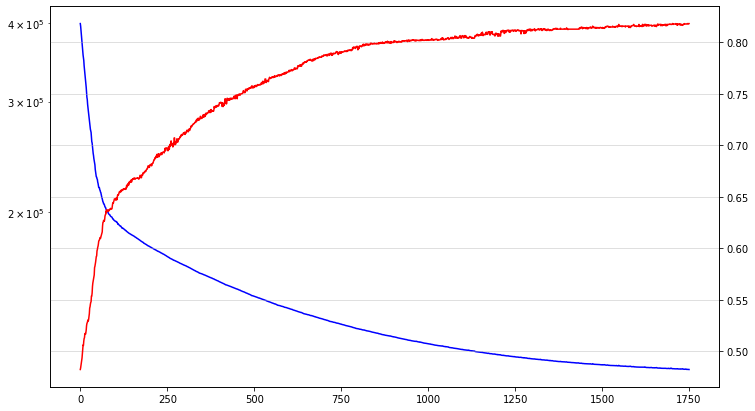

In [63]:
y = train_data['covid']
X = train_data.drop(['covid','risk','spread'],axis=1)  
clf = SoftSVM(C=1e2, lr=1e-5)

losses, accuracies = clf.fit_with_logs(np.array(X), np.array(y), max_iter=1750)
fig = plt.figure(figsize=(12, 7))
ax1 = fig.add_subplot(111)
line1 = ax1.semilogy(losses, c='b', label='?')
ax2 = ax1.twinx()
line2 = ax2.plot(accuracies, c='r', label='?')
ax2.grid(alpha=0.5)
plt.show()

In [65]:
print(max(accuracies))

0.8229166666666666


0.0001 0.8266666666666668


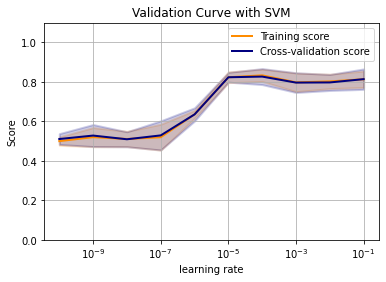

In [77]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2)
PCR_data = train_data[['PCR_03','PCR_07','PCR_10']].copy()
PCR_data2 = poly.fit_transform(PCR_data)
lr_range = np.logspace(-10, -1, 10)

train_scores, test_scores  = sklearn.model_selection.validation_curve(SoftSVM(1000),PCR_data2,spreads,param_name='lr',param_range=lr_range,cv = 8)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.title("Validation Curve with SVM")
plt.xlabel(r"$\k$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(
    lr_range, train_scores_mean, label="Training score", color="darkorange", lw=lw
)
plt.fill_between(
    lr_range,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.2,
    color="darkorange",
    lw=lw,
)
plt.semilogx(
    lr_range, test_scores_mean, label="Cross-validation score", color="navy", lw=lw
)
plt.fill_between(
    lr_range,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.2,
    color="navy",
    lw=lw,
)
ymax = max(test_scores_mean)
index = np.argmax(test_scores_mean)
print(lr_range[index],ymax)
plt.grid()
plt.legend(loc="best")
plt.xlabel("learning rate")
plt.show()